# Ejemplo de uso de Whisper para reconocimiento de habla

En este cuaderno vamos a utilizar el modelo [Whisper](https://openai.com/blog/whisper/) de OpenAI para crear un ejemplo de reconocimiento de voz. Podremos utilizar como entrada la grabación del audio de un micrófono o ficheros de audio grabados previamente o descargados de YouTube.

Los componentes que vamos a usar en el ejemplo van a ser:
- **Whisper:** para hacer la transcripción audio-texto
- **JiWER**: para evaluar la calidad del reconocimiento de voz
- **PyTube:** librería Python para descargar vídeos de Youtube
- **Gradio:** librería para construir aplicaciones web para demo de modelos de ML


## Instalación de Whisper
La instalación es muy sencilla. Solo tenemos que usar pip 

In [1]:
! pip install git+https://github.com/openai/whisper.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 KB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Información general y carga del modelo

Whisper es un modelo para reconocimiento del habla entrenado con **680.000 horas** de audio de diferentes idiomas.

* Es un modelo **multiidioma**, es decir, es capaz de realizar transcripción audio a texto para varios idiomas. 
* Es un modelo **multitarea**, porque también puede realizar **traducción automática** o **detección de idioma**. 
* Entrenado como un modelo *end2end (E2E)* con un enfoque **supervisado** (se requiere un conjunto de datos etiquetado de gran tamaño que han trabajado con un enfoque *weakly supervised*, con transcripciones que generadas por personas combinadas con otras automáticas). 

  ***Nota:*** a grandes rasgos, la diferencia entre aproximación *E2E* e *híbrida* es que en la aproximación *híbrida* el sistema de reconocimiento de voz se construye entrenando por separado un modelo acústico y un modelo de lenguaje, mientras que en *E2E* tenemos *una sóla pieza*) 

Existen varias versiones del modelo: a mayor tamaño, mayor precisión pero también más tiempo de computación (la precisión en reconocimiento de voz puede ir bajar de 30% WER a 10% WER)

El modelo se publicó **a finales de septiembre de 2022**, y en diciembre se publicó una nueva versión de su modelo *large* (large-v2) entrenado con más del doble de epochs  con mejoras de rendimiento.

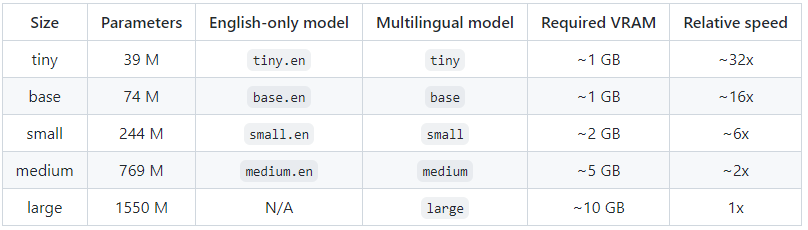
language-breakdown.svg

In [2]:
import whisper

model = whisper.load_model("large-v2")


100%|██████████████████████████████████████| 2.87G/2.87G [00:12<00:00, 257MiB/s]


## Comprobamos que tenemos una GPU

Deberíamos ver como salida `device(type='cuda', index=0)`. Si no, funcionaría más lento, aunque podemos ir a `Runtime->Change Runtime Type` para cambiarlo.

In [3]:
model.device

device(type='cuda', index=0)

## Subida de fichero de audio

Subimos los ficheros de audio que queramos transcribir. En este primer ejemplo vamos a utilizar una entrevista en español para testear el funcionamiento del modelo con **habla general** (más adelante repetiremos la prueba con habla **específica del dominio** de la medicina).


In [5]:
from IPython.display import Audio
Audio("/content/marie_curie_canalhistoria.mp3")

## Transcripción del fichero por código


In [6]:

from whisper.utils import ResultWriter
import time

st = time.time()
result = whisper.transcribe(audio="/content/marie_curie_canalhistoria.mp3", model=model)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

print(result["text"])
rw = whisper.utils.WriteSRT(ResultWriter("/content/"))
rw.write_result(result=result, file = open("/content/marie_curie_canalhistoria.srt", "w"))



Execution time: 90.215256690979 seconds
 Ningún científico ha gozado de tanta popularidad mundial. Fue la primera en investigar el fenómeno de la radiactividad y descubrió elementos radiactivos desconocidos para la ciencia. Fue la primera mujer que se doctoró en la Sorbona. La primera mujer que obtuvo el premio Nobel y la única que recibió el prestigioso galardón dos veces. Su nombre era María Slodovska-Kurí. Nació en Varsovia en el año 1867 en el seno de una familia dedicada a la enseñanza. Los Slodovskis intentaron inculcar a sus cinco hijos el amor por el conocimiento. Las ciencias exactas eran especialmente valoradas en esa casa. A los 16 años, María dejó el instituto graduándose con matrícula de honor. En Polonia, que en aquel entonces formaba parte del imperio ruso, no había instituciones donde las mujeres pudiesen seguir estudiando y su familia no tenía dinero para enviar a sus hijas a estudiar al extranjero. Entonces, María propuso que su hermana mayor debería ir a estudiar a P

## Cálculo de la tasa de error

La medida clásica para evaluar la calidad de un sistema de reconocimiento de voz es el WER (Word Error Rate), aunque hay otras ya que en el WER podría decirse que *todos los errores son igual de importantes* pero no es así.

Utilizaremos JiWER (Similarity measures for automatic speech recognition evaluation) para evaluarla.

Una particularidad a la hora de evaluar los nuevos modelos de reconocimiento del habla:
* Tradicionalmente, se han evaluado las transcripciones *raw" o *machine-readable*: solo texto, sin signos de puntuación (a menos que se digan explícitamente), *case-insensitive*, etc. 
* Whisper es capaz de darnos transcripciones *human readable* que automáticamente te dan puntos, comas, formateo a mayúsculas, etc.


En este caso vamos a ver la tasa de acierto con audios específicos del dominio de la medicina.

In [7]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.2 MB/s eta 0:00:00


In [8]:
from jiwer import wer

result_cardiologia = whisper.transcribe(audio="/content/cardiologia.wav", model=model)
print(result_cardiologia['text'])

result_medicina_general = whisper.transcribe(audio="/content/medicina_general.wav", model=model)
print(result_medicina_general['text'])

ground_truth_cardiologia = "Se realizó ecocardiografía de estrés que resultó positiva para inducción de isquemia miocárdica, sugiriendo enfermedad multivaso con fracción de eyección conservada."
ground_truth_medicina_general = "en sigma, pólipo pediculado descrito previamente que se extirpa tras sobreelevación con Voluven más azul de metileno."


error_cardiologia = wer(ground_truth_cardiologia, result_cardiologia['text'])
error_medicina_general = wer(ground_truth_medicina_general, result_medicina_general['text'])
print('Error Cardiología = ' + str(error_cardiologia))
print('Error Medicina General = ' + str(error_medicina_general))

 Se realizó ecocardiografía de estrés que resultó positiva para inducción de isquemia miocárdica, sugiriendo enfermedad multivaso con fracción de eyección conservada.
 En SIGMA, polipo pediculado descrito previamente que se estirpa atrás sobre elevación con volumen más azul de metileno.
Error Cardiología = 0.0
Error Medicina General = 0.47058823529411764


## Transcripción del fichero por línea de comandos

In [9]:
import torch
torch.cuda.empty_cache()
!whisper "/content/audio_entrevista_Luis_Enrique.mp3" --task transcribe --model large --language Spanish --verbose False --output_dir audio_transcription_large

^C


## Transcripción de un vídeo de Youtube

Transcribimos un vídeo de YouTube a partir de una URL. Descargamos el audio usando PyTube

In [10]:
# Instalación de PyTube
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 KB 8.1 MB/s eta 0:00:00


In [11]:
import pytube as pt

# Descargamos el audio
yt = pt.YouTube("https://www.youtube.com/watch?v=dzeinAXsLRc")
stream = yt.streams.filter(only_audio=True)[0]
stream.download(filename="islas_canarias.mp3")

# Transcripción
result = whisper.transcribe(audio="islas_canarias.mp3", model = model)
print(result['text'])

 La furia de la naturaleza sigue dibujando el paisaje de las islas canarias. Acaba de producirse la erupción volcánica en la isla de La Palma. Abriendo ventanas al interior de la tierra. Qué profundo que está. Una fractura que quedó abierta de la erupción, en la que todavía se puede ver incandescencia. Con ambientes letales. Hay el triple de concentración de CO2 que hay en el aire. Esto puede ocasionar la muerte en cuestión de segundos. Bajo la amenaza permanente de nuevas erupciones. ¿Qué ocurriría si sucediese una erupción en el Teide? No existiríamos sin los volcanes. Tenemos que aprender a vivir con ellos. Islas Canarias. Nacidas del fuego. Estreno el lunes 12 de septiembre a las 10 en National Geographic.


# Traducimos el audio a otro idioma

In [12]:
from whisper.utils import ResultWriter
result = model.transcribe(audio="/content/islas_canarias.mp3", task='translate', language='en')
rw = whisper.utils.WriteSRT(ResultWriter("/content/"))
rw.write_result(result=result, file = open("/content/traduccion_islas_canarias.srt", "w"))


## Instalación the Gradio

Usamos Gradio para insertar un widget de grabación de audio

In [13]:
! pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.3 MB/s eta 0:

In [14]:
import gradio as gr 
import time

In [15]:
def transcribe(audio):
    
    # load audio and pad/trim it to fit 30 seconds
    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    # make log-Mel spectrogram and move to the same device as the model
    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    # detect the spoken language
    _, probs = model.detect_language(mel)
    print(f"Detected language: {max(probs, key=probs.get)}")

    # decode the audio
    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    print(result)
    return result.text

## Interfaz web para grabación de audio

Widget para grabación de audio con micrófono.

In [16]:
gr.Interface(
    title = 'Ejemplo Taller: Gradio + Whisper', 
    fn=transcribe, 
    inputs=[
        gr.inputs.Audio(source="microphone", type="filepath")
    ],
    outputs=[
        "textbox"
    ],
    live=True).launch()

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:319: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## Las novedades no paran 🚀

* [Fine tuning de Whisper](https://huggingface.co/blog/fine-tune-whisper)

* [Implementaciones ligeras en CPU](https://github.com/ggerganov/whisper.cpp)

* **15 de febrero:** se anuncia Gladia, un API que usa Whisper Large-V2...pero que lo han mejorado en velocidad y precisión
  * [Artículo](https://medium.com/@gladia.io/gladia-alpha-launch-redefining-what-s-possible-with-speech-to-text-ai-686dd4312a86)

  * [Space HuggingFace](https://huggingface.co/spaces/Gladiaio/Audio-Transcription)
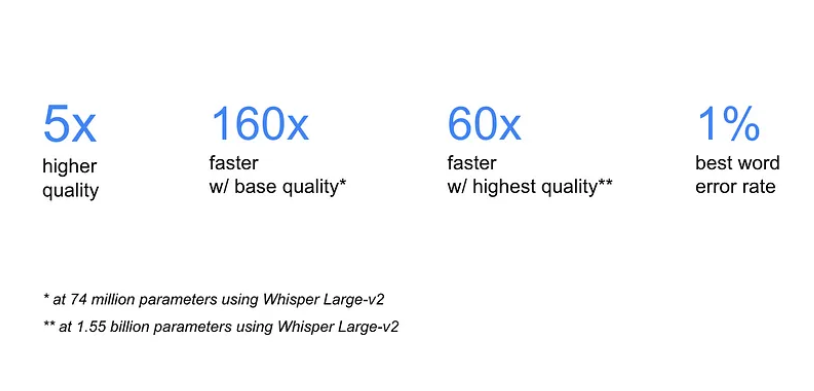
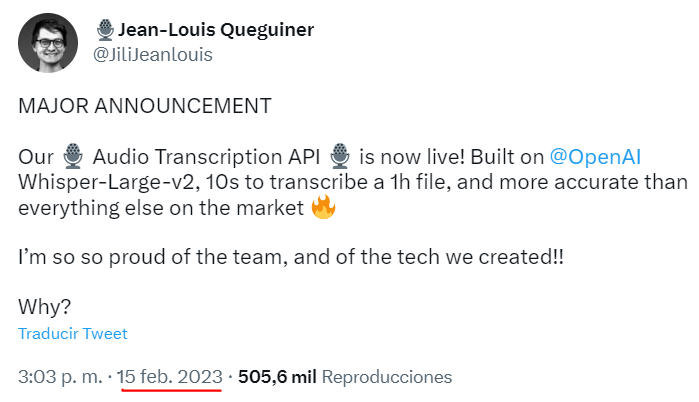


